In [1]:
%matplotlib inline

import numpy as np
from numpy.fft import fft, ifft, fftfreq, fftshift
import matplotlib.pyplot as plt

import numpy.random as rng
rng.seed(872364892)


# make useable region the width of the browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# make figures larger
plt.rcParams['figure.dpi'] = 150


from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle source'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

In today's notebook we will consider the problem of finding periodic behavior in unevenly-sampled time series with a view to fitting models to such data.

First, however, let's examine what this might mean. The time-sequence of flux observations of a variable source is known in astronomy as the *light-curve*, though today this might be extended to include gravitaitonal waves, neutrinos, and other sorts of non-photonic observations!

We often have sparsely- and irregularly-sampled lightcurves obtained as times  {(𝑡𝑜𝑏𝑠,𝑖,𝑓𝑜𝑏𝑠,𝑖)}, 𝑖=1,…,𝑁𝑜𝑏𝑠  In many cases these lightcurves exhibit periodic behavior with one or more periods.
For example, the lightcurve of a pulsating star may contain multiple periods due to various modes of oscillation, or the lightcurve of an eclipsing exoplanetary system may have eclipses from multiple planets.

Jacob VanderPlas wrote a very thorough introduction to one popular method of period-finding in unequally-spaced data, the *Lomb-Scargle periodogram*. Many of the examples in this notebook are drawn from his paper.

We start with a reminder of how uniform sampling affects the Fourier transform of a signal. Here are four functions and their discrete Fourier transforms (computed by the FFT algorithm, of course):

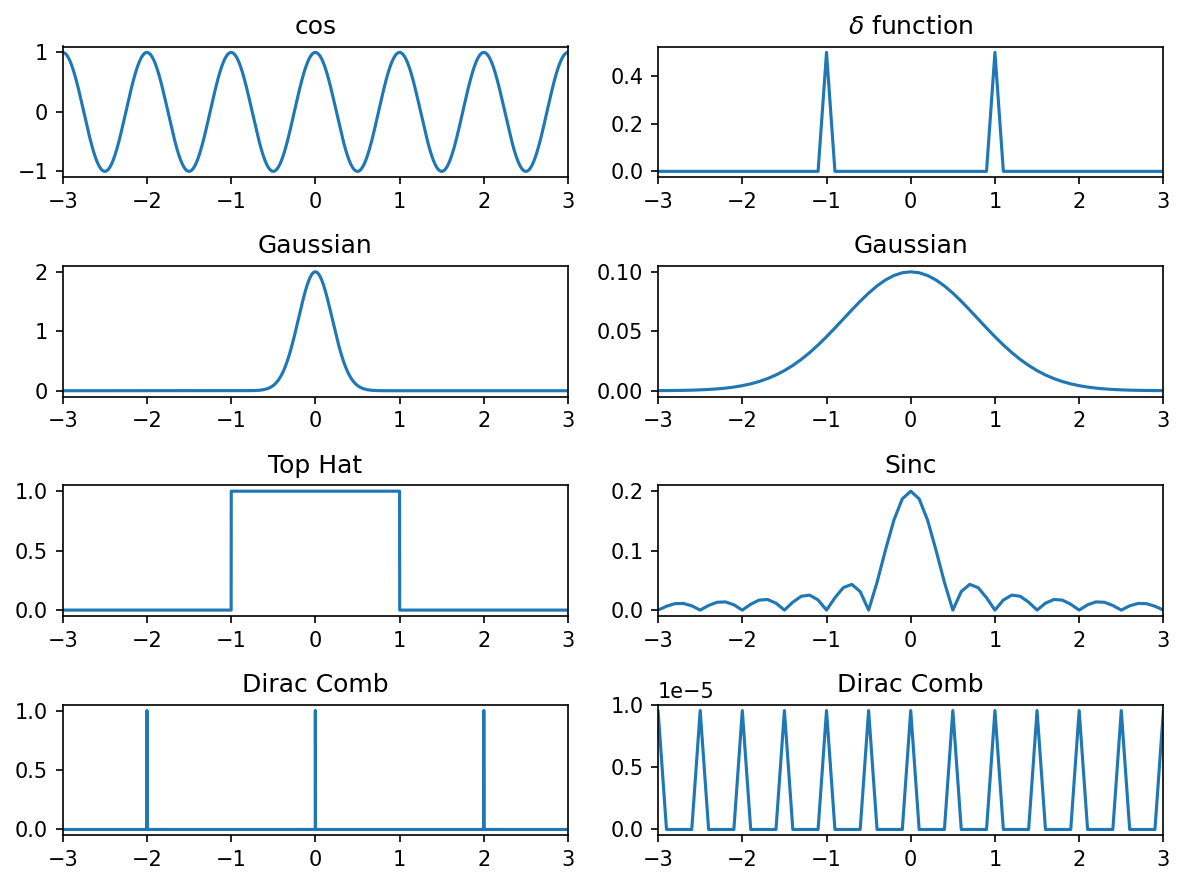

In [2]:
def gaussian(x, mu, sig):
    return 1/(np.sqrt(2*np.pi)*sig)*np.exp(-0.5*(x-mu)**2/sig**2)

fig, ax = plt.subplots(4,2, figsize=(8,6))

N = 2**20
T = 10
t = np.linspace(-T/2,T/2, N)
dt = t[1]-t[0]
s = np.cos(2*np.pi*t)
ax[0,0].plot(t, s)
ax[0,0].set_xlim(-3,3)
ax[0,0].set_title("cos")
ffts = np.abs(fftshift(fft(s)))/N
f = fftshift(fftfreq(N,dt))
ax[0,1].plot(f, ffts)
ax[0,1].set_xlim(-3,3)
ax[0,1].set_title("$\delta$ function")

s = gaussian(t,0,0.2)
ax[1,0].plot(t,s)
ax[1,0].set_xlim(-3,3)
ax[1,0].set_title("Gaussian")
ffts = np.abs(fftshift(fft(s)))/N
ax[1,1].plot(f,ffts)
ax[1,1].set_xlim(-3,3)
ax[1,1].set_title("Gaussian")

s = np.where( np.abs(t)<1, 1, 0)
ax[2,0].plot(t,s)
ax[2,0].set_xlim(-3,3)
ax[2,0].set_title("Top Hat")
ffts = np.abs(fftshift(fft(s)))/N
ax[2,1].plot(f,ffts)
ax[2,1].set_xlim(-3,3)
ax[2,1].set_title("Sinc")

s = np.zeros(N)
s = np.where( np.abs(t/2-np.floor(t/2))<1.1*dt, 1, 0)
ax[3,0].plot(t,s)
ax[3,0].set_xlim(-3,3)
ax[3,0].set_title("Dirac Comb")
ffts = np.abs(fftshift(fft(s)))/N
ax[3,1].plot(f,ffts)
ax[3,1].set_xlim(-3,3)
ax[3,1].set_title("Dirac Comb")

fig.tight_layout()

hide_toggle()

Recall the effect of a uniform window function on a periodic signal -- a finite duration of measurement, but effectively infinite sampling. (The fact that the transform of the signal is not a set of $\delta$ functions is due to the use of the DFT with finite sampling.)

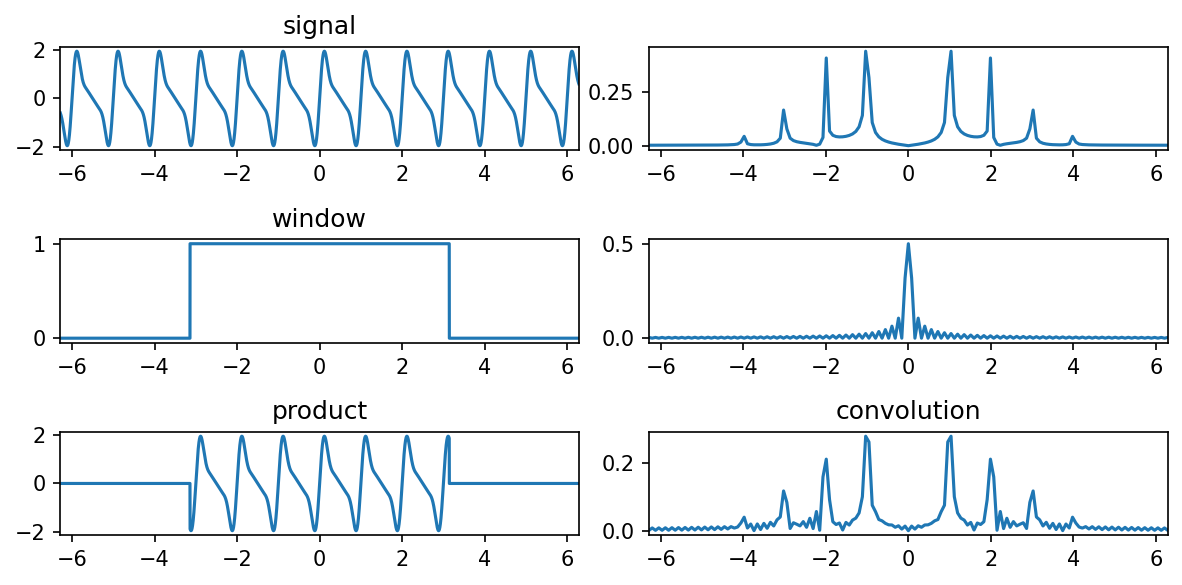

In [6]:
N = 2**20
T = 2*np.pi
t = np.linspace(-T,T,N)
dt = t[1]-t[0]
fig, ax = plt.subplots(3,2,figsize=(8,4))

s = 1.2*np.sin(2*np.pi*t) + 0.8*np.sin(4*np.pi*t) + 0.4*np.sin(6*np.pi*t) + 0.1*np.sin(8*np.pi*t)
ax[0,0].plot(t,s)
ax[0,0].set_xlim(-2*np.pi, 2*np.pi)
ffts = np.abs(fftshift(fft(s)))/N
f = fftshift(fftfreq(N,dt))
ax[0,1].plot(f,ffts)
ax[0,1].set_xlim(-2*np.pi, 2*np.pi)
ax[0,0].set_title("signal")

w = np.where( np.abs(t)<np.pi, 1, 0)
ax[1,0].plot(t,w)
ax[1,0].set_xlim(-2*np.pi, 2*np.pi)
fftw = np.abs(fftshift(fft(w)))/N
f = fftshift(fftfreq(N,dt))
ax[1,1].plot(f,fftw)
ax[1,1].set_xlim(-2*np.pi, 2*np.pi)
ax[1,0].set_title("window")

ax[2,0].plot(t,s*w)
ax[2,0].set_xlim(-2*np.pi, 2*np.pi)
fftsw = np.abs(fftshift(fft(s*w)))/N
f = fftshift(fftfreq(N,dt))
ax[2,1].plot(f,fftsw)
ax[2,1].set_xlim(-2*np.pi, 2*np.pi)
ax[2,0].set_title("product")
ax[2,1].set_title("convolution")

fig.tight_layout()

hide_toggle()

Here is the effect of regularly sampling the input waveform with a period of $\Delta t$: the transform of the signal with frequencies on $[-1/\Delta t,1/\Delta t]$ and an infinite sequence of aliases above and below this frequency interval.

Thus, evaluating the transform on $f$ on $[-1/\Delta t,1/\Delta t]$ is sufficient to capture all the information in the windowed signal. In this example, $\Delta t=1$:

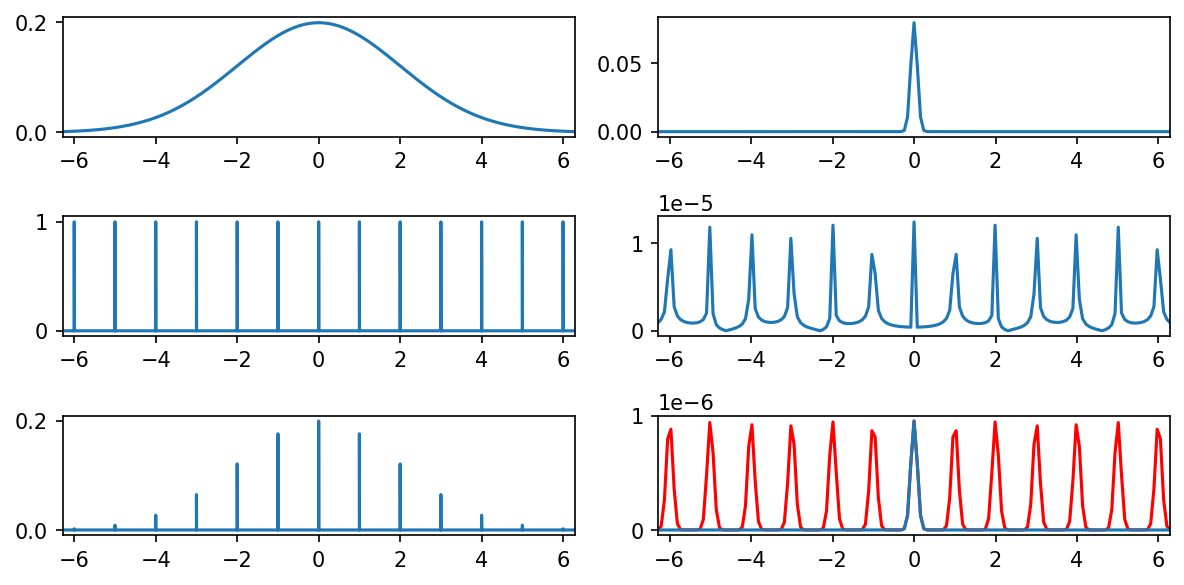

In [7]:
N = 2**20
T = 2*np.pi
t = np.linspace(-T,T,N)
dt = t[1]-t[0]
fig, ax = plt.subplots(3,2,figsize=(8,4))

w = np.where( np.abs(t-np.floor(t))<1.1*dt, 1, 0)
s = gaussian(t,0,2)
ax[0,0].plot(t,s)
ax[0,0].set_xlim(-2*np.pi, 2*np.pi)
ffts = np.abs(fftshift(fft(s)))/N
f = fftshift(fftfreq(N,dt))
ax[0,1].plot(f,ffts)
ax[0,1].set_xlim(-2*np.pi, 2*np.pi)

ax[1,0].plot(t,w)
ax[1,0].set_xlim(-2*np.pi, 2*np.pi)
fftw = np.abs(fftshift(fft(w)))/N
f = fftshift(fftfreq(N,dt))
ax[1,1].plot(f,fftw)
ax[1,1].set_xlim(-2*np.pi, 2*np.pi)

ax[2,0].plot(t,w*s)
ax[2,0].set_xlim(-2*np.pi, 2*np.pi)
fftw = np.abs(fftshift(fft(w*s)))/N
f = fftshift(fftfreq(N,dt))
ax[2,1].plot(f,fftw, 'r')
rat = fftw[N//2]/ffts[N//2]
ax[2,1].plot(f,rat*ffts,color=u'#1f77b4')
ax[2,1].set_xlim(-2*np.pi, 2*np.pi)


fig.tight_layout()

hide_toggle()

Irregularly-spaced observations can be thought of by replacing the evenly-spaced Dirac comb by a sequnce of $\delta$-functions at the times of observation:

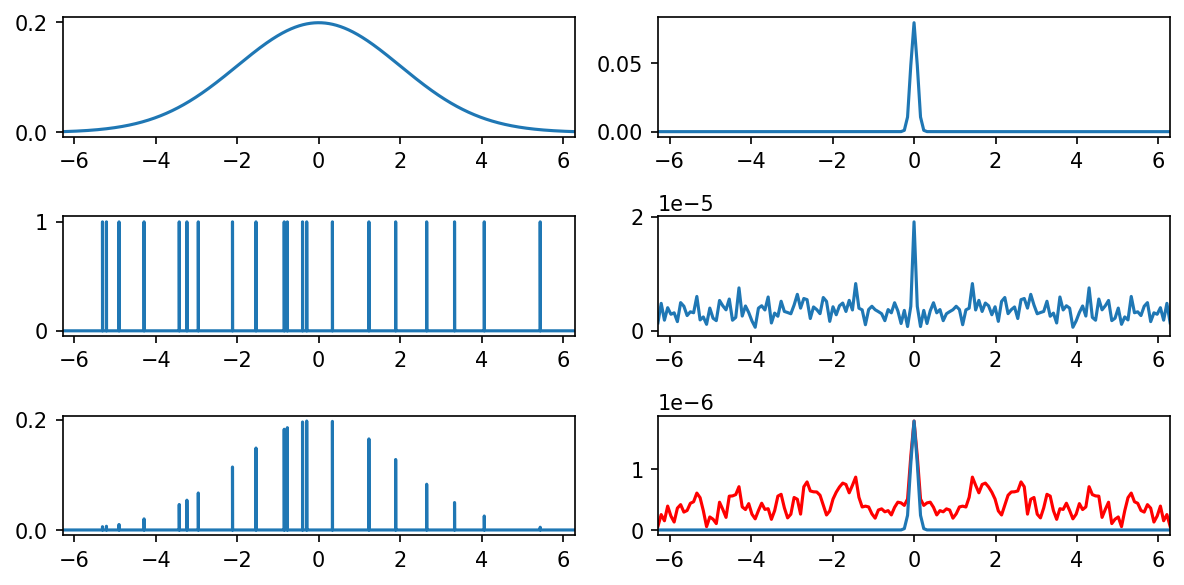

In [5]:
N = 2**20
T = 2*np.pi
t = np.linspace(-T,T,N)
dt = t[1]-t[0]
fig, ax = plt.subplots(3,2,figsize=(8,4))

w = np.zeros(N)
idx = (N*rng.rand(20)).astype(int)
w[idx] = 1
s = gaussian(t,0,2)
ax[0,0].plot(t,s)
ax[0,0].set_xlim(-2*np.pi, 2*np.pi)
ffts = np.abs(fftshift(fft(s)))/N
f = fftshift(fftfreq(N,dt))
ax[0,1].plot(f,ffts)
ax[0,1].set_xlim(-2*np.pi, 2*np.pi)

ax[1,0].plot(t,w)
ax[1,0].set_xlim(-2*np.pi, 2*np.pi)
fftw = np.abs(fftshift(fft(w)))/N
f = fftshift(fftfreq(N,dt))
ax[1,1].plot(f,fftw)
ax[1,1].set_xlim(-2*np.pi, 2*np.pi)

ax[2,0].plot(t,w*s)
ax[2,0].set_xlim(-2*np.pi, 2*np.pi)
fftw = np.abs(fftshift(fft(w*s)))/N
f = fftshift(fftfreq(N,dt))
ax[2,1].plot(f,fftw, 'r')
rat = fftw[N//2]/ffts[N//2]
ax[2,1].plot(f,rat*ffts,color=u'#1f77b4')
ax[2,1].set_xlim(-2*np.pi, 2*np.pi)


fig.tight_layout()

hide_toggle()

The result appears to be a "noisy" transform, but this noise is not due to random variations in the signal amplitude but rather due to the random sampling intervals.

As an example lightcurve drawn from real life, here are some observations made by LINEAR (LIncoln Near-Earth Asteroid Research) of an object they identified as 11375941, likely an SX Phoenicis star, a pulsating main-sequence star likely formed from the merger of a close binary (a "blue straggler").

At first glance, this light curve certainly seens inscrutable!

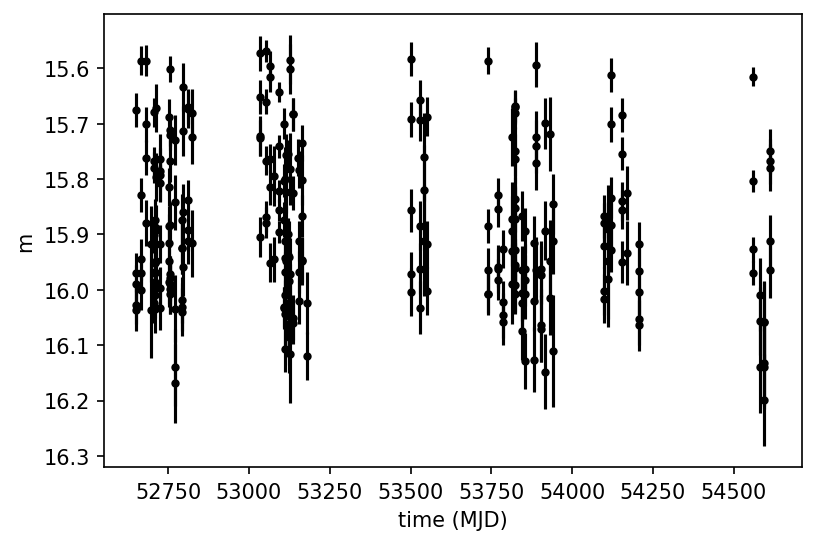

In [8]:
tobs, mobs, merr = np.genfromtxt('LINEAR_11375941.csv', delimiter=',').T
fig, ax = plt.subplots()
ax.errorbar(tobs, mobs, merr, fmt='k.')
ax.set(xlabel='time (MJD)', ylabel='m')
ax.invert_yaxis()

In [15]:
T = tobs[-1]-tobs[0]
print(T, 1/T)

1961.8473650000014 0.0005097236501882496


The period of observation is $T=1961.847365$ days, so the longest period (lowest frequency) we can hope to extract from the data is $T$ ($0.0005$ d$^{-1}$).

What is the analog of the Nyquist frequency, the highest frequency signal we can extract which is not aliased? One might take the mean time between observations

In [17]:
meandt = ( tobs[1:]-tobs[:-1]).mean()
print(f"mean delta-t: {meandt: .4f} days")
print(f'"Nyquist": {2/meandt: .4e} per day   {2/(24*meandt): .4f} per hour')

mean delta-t:  7.0317 days
"Nyquist":  2.8443e-01 per day    0.0119 per hour


Of course, many of the observations are spaced more closely than the mean separation, so there must be some information content at higher frequencies. The smallest $\Delta t$ is about 9 seconds, but at 
the corresponding Nyquist frequency the signal must be heavily polluted by aliasing from segments of the signal sampled at longer intervals.

This is both the advantage and disadvantage of irregularly-spaced observations. With the same number of samples, we can obtain information about the frequency content of the signal in a much wider bandwidth than would be the case with uniform sampling, but the analysis is more subtle due to the effects of aliasing.

This example was chosen because it is, indeed, periodic. If we were to fold the data *moduluo* the correct period $P$, observation times from one period would then lie close to other times from another period, leading to even better sampling, albeit a sampling which depends upon whic folding period we choose.

Given a lightcurve, the *phases* moduluo $P$ of the observation times $t_i$ are
$$ \phi_i = \frac{t_i}{P} - \left\lfloor \frac{t_i}{P} \right\rfloor $$

The analog of the Nyquist frequency for unevenly-sampled data thus has more to do with the spacing of
the phase samples than with the spacing of the observations themselves.

Another upper limit to the frequencies we should be able to detect comes from the precision with which the observation times are recorded. This may not be a very practical limit, but in principle there is information in the signal about such large frequencies (short periods), and any power above this frequency will be aliased into lower frequencies.

Yet another limit on the frequencies we should be able to detect comes from the exposure time of each individual observation. If the exposure time is $\delta t$, then our signal has been convolved with a window function of that width. As we saw above, this will place a limit $\propto 1/\delta t$ on the maximum frequency which can be observed. This limit is different in character, as there is no power at higher frequencies; the signal has been low-pass filtered by the observation process itself.

At the low-frequency end, if the data set covers a duration $T$, then a frequency of $1/T$ will
just fill the observed interval with one period.

Thus, we can only obtain information between a low-frequency limit of $f_{min}\sim1/T$ and a high-frequency limit as described above. For our linear data, with a duration of $1962$ days, this puts the range between $f_{min}\sim 5\times10^{-4}$~d$^{-1}$ and $f_{\max}\sim8\times10^{3}$ ~d$^{-1}$.

If we think of the duration the observations as a rectangular window function of width $T$, then the width of the Fourier transform of that window is $\sim 1/T$. That is, if the signal were a pure sinusoid, the peak in the PSD would have about that width.

What this means is that, not only is the range of possible frequencies quite large, if we don't sample this frequency spectrum finely enough we may miss entirely the signal we are looking for! It is recommended that one oversample by a factor of five to ten, so that at the very least we should be
looking to compute the PSD at $\sim 5 T f_{max}$ frequencies. For our LINEAR data, this is of order $8\times 10^7$ frequencies!

Clearly, one needs to use some judgement about what set of frequencies to explore based upon what what one expects to find in the data.

Skipping ahead a bit, we can use a *periodogram*, an estimator of the PSD of the signal, to examine the LINEAR window function.

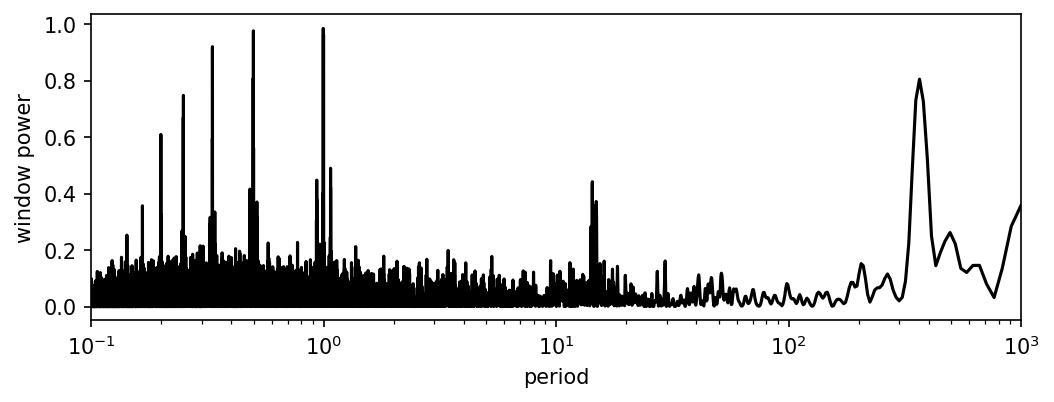

In [27]:
from astropy.timeseries import LombScargle

ls = LombScargle(tobs, 1, fit_mean=False, center_data=False)
freqW, powerW = ls.autopower(minimum_frequency=0.001, maximum_frequency=24)

fig, ax = plt.subplots(figsize=(8, 3))
fig.subplots_adjust(bottom=0.2)
ax.set_xscale('log')
ax.plot(1. / freqW, powerW, '-k', rasterized=True)

ax.set(xlabel='period',
       ylabel='window power',
       xlim=(0.1, 1000));

hide_toggle()

There is quite a bit of structure in this window function. We can see a strong signal at one day, an unavoidable consequence of a telescope on the ground. There is a sequence of aliases of one day at shorter periods of $1/n, n=2,\dots$ days. There is also a strong signal around 365 days, possibly due to the weather pattern at White Sands, NM (clear in winter, cloudy during the summer monsoon) and possibly due to scheduling. There is also a strong peak at about 14 days, likely due to scheduling.

Here is a zoom-in on the window function at short periods:

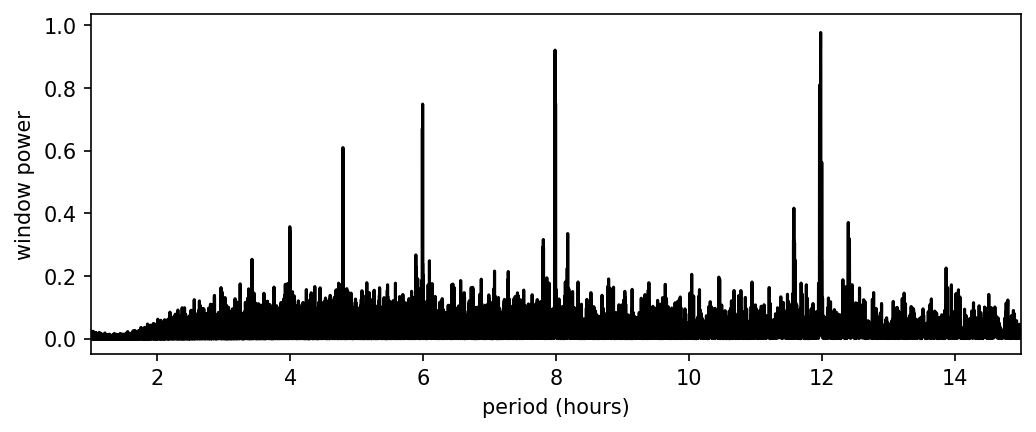

In [26]:
s = LombScargle(tobs, mobs, merr)
freq, power = ls.autopower(minimum_frequency=0.001, maximum_frequency=35)

period_days = 1. / freq
period_hours = 24. / freq

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(period_hours, power, '-k', rasterized=True)

ax.set(xlim=(1, 15),
       xlabel='period (hours)',
       ylabel='window power');

hide_toggle()

All of this structure will, unavoidably, be present in the power spectrum of the observational data itself.

We mentioned above that the example data are indeed periodic. The best-fit period is around $P = 2.5801358$ hours. Folding the data with this period gives

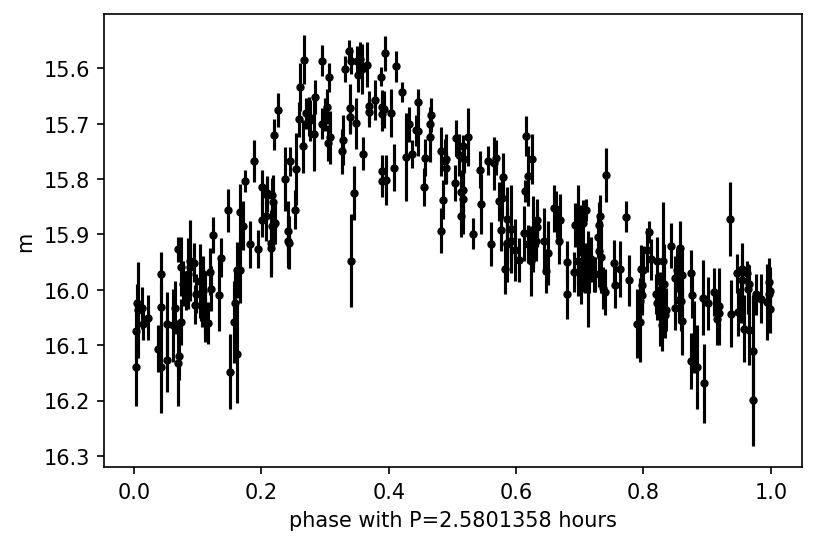

In [30]:
def getPhases(t, P):
    return t/P - np.floor(t/P)

P = 2.5801358 / 24 # data in days
phases = getPhases(tobs, P)

fig, ax = plt.subplots()
ax.errorbar(phases, mobs, merr, fmt='k.')
ax.set(xlabel=f'phase with P={P*24:.7f} hours', ylabel='m')
ax.invert_yaxis()

We also mentioned that the width of the spectral peak is $\sim1/T$. Here we fold with a period 
$P^\prime = P (1+1/T)$

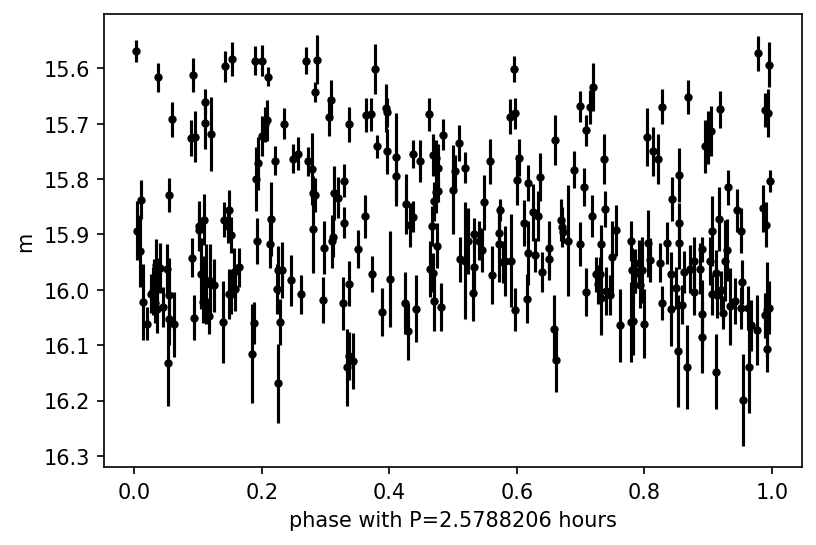

In [32]:
P = 2.5801358 / 24 # data in days
Pp = P*(1-1/T)
phases = getPhases(tobs, Pp)

fig, ax = plt.subplots()
ax.errorbar(phases, mobs, merr, fmt='k.')
ax.set(xlabel=f'phase with P={Pp*24:.7f} hours', ylabel='m')
ax.invert_yaxis()

There is a great deal of difference in these two plots! This suggests a statistic for measuring the disorder. Since our prior (informally) is that the properly-folded data should be smooth, adjacent points in the folded data should be close in value. Ignoring the errors for now,
$$ s = \sum_{i=1}^{N-1} (m_{i+1}-m_i)^2 $$
where the measurements $m_i$ are ordered by phase.

In [35]:
def stat(t, m, P):
    phases = getPhases(t,P)
    indx = np.argsort(phases)
    return np.sum( (m[indx[1:]] - m[indx[:-1]])**2 )

We can evaluate this statistic for a grid of frequencies around $1/P$, spaced by $1/(5T)$

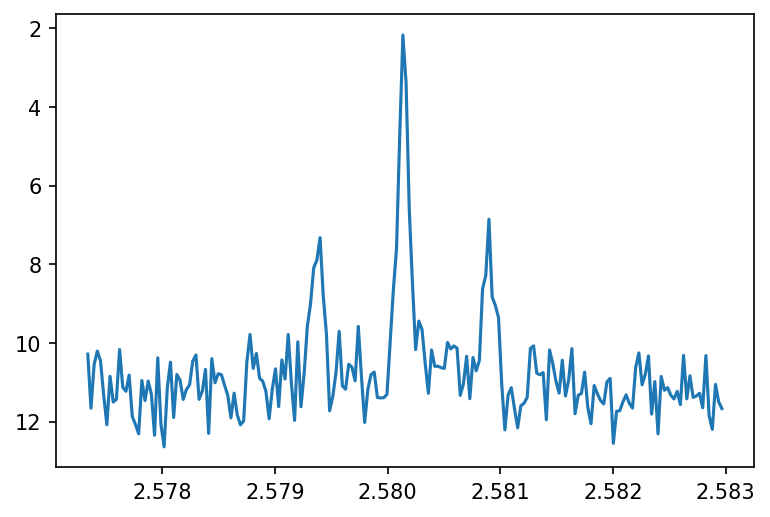

In [46]:
f0 = 1/(P)
df = 1/(5*T)
f = f0 + df*np.arange(-100,100)
stats = np.zeros(len(f))
for i in range(len(f)):
    stats[i] = stat(tobs, mobs, 1/f[i])
    
fig, ax = plt.subplots()
ax.plot(24/f, stats)
ax.invert_yaxis()

Pretending that we didn't already know $P$, we can search the period range from a minimum of, say, one hour to a maximum of a day (so that the computation doesn't take too long).

searching 225613 frequencies


[Text(0.5, 0, 'period (hours)'), Text(0, 0.5, 'statistic')]

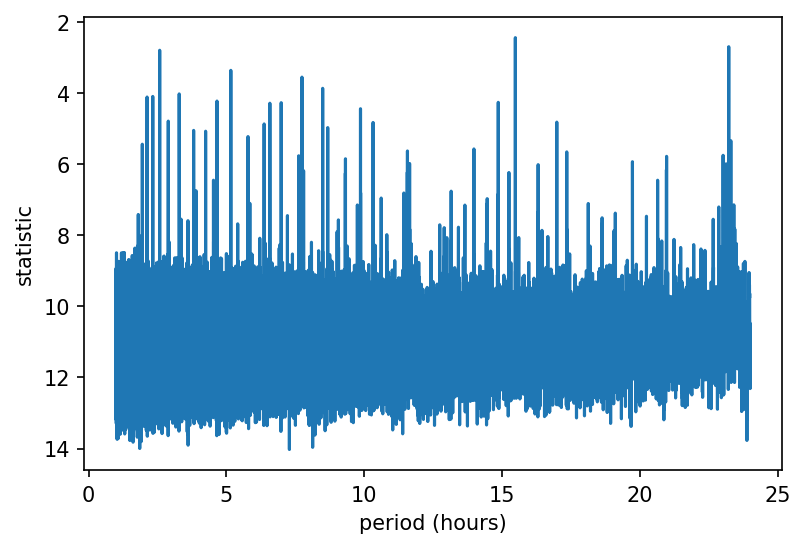

In [53]:
Pmin = 1/24
Pmax = 1
fmin, fmax = 1/Pmax, 1/Pmin
df = 1/(5*T)
f = np.arange(fmin, fmax, df)
print(f"searching {len(f)} frequencies")
stats = np.zeros(len(f))
for i in range(len(f)):
    stats[i] = stat(tobs, mobs, 1/f[i])
    
fig, ax = plt.subplots()
ax.plot(24/f, stats)
ax.invert_yaxis()
ax.set(xlabel='period (hours)', ylabel='statistic')

Sure enough, there is a peak at 2.58 hours, but how to tell which peak is real and which a function of noise and of aliasing?

(0.0, 10.0)

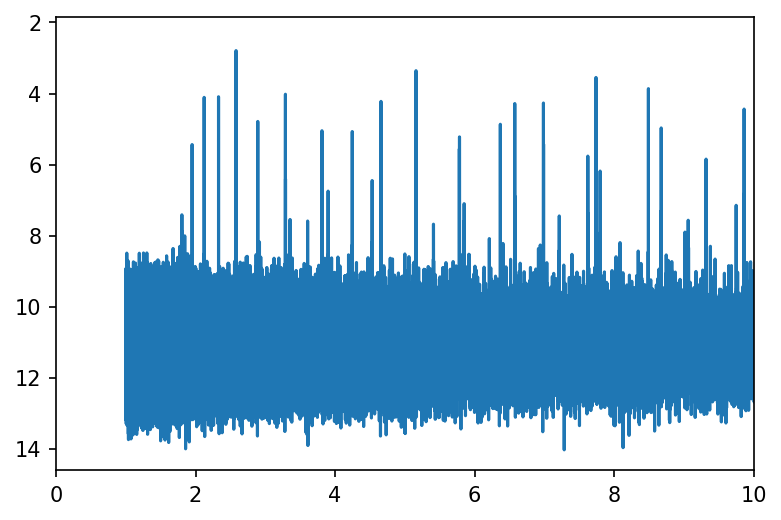

In [55]:
fig, ax = plt.subplots()
ax.plot(24/f, stats)
ax.invert_yaxis()
ax.set_xlim(0, 10)

We could refine our algorithm smoothing the phased data. Convolve the phased data with a window function of width $w<1$; this is known as "boxcar" smoothing, and will reduce the effects of uncorrelated noise. We can then form the $\chi^2$ statistic
$$ \chi^2 = \frac{\sum_{i=1}^N(m_i - \overline{m})^2}{\sum_{i=1}^N (m_i - s_i)^2} $$
where the $m_i$ are the phased observations, the $s_i$ are the smoothed, phased observations, and $\overline{m}$ is the mean of the data. The numerator is just the sample mean, and the denominator a measure of the dispersion about a smoothed version of the data.

In [58]:
# boxcar smoothing of data by w with t on [0,1]
def smooth(t, d, w):
    nw = len(t)/w
    n = len(t)
    s = np.zeros_like(d)
    for i in range(n):
        tmp = np.where( (t>=t[i]-w)&(t<=t[i]+w), d, 0 )
        s[i] = np.sum(tmp)/np.count_nonzero(tmp)
    return s

def sstat(t, d, w, P):
    ph = getPhases(t, P)
    indx = np.argsort(ph)
    tp = ph[indx]
    dp = d[indx]
    s = smooth(tp, dp, w)
    denom = np.sum( (dp-s)** 2 )
    dpmean = dp.mean()
    num = np.sum( (dp-dpmean)**2 )
    return num/denom


searching 225613 frequencies


[Text(0.5, 0, 'period (hours)'), Text(0, 0.5, '$\\chi^2$')]

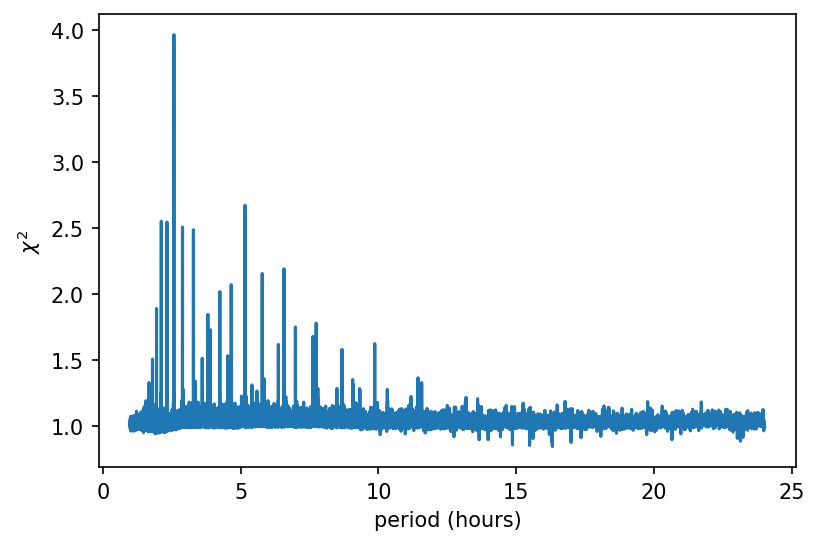

In [63]:
Pmin = 1/24
Pmax = 1
fmin, fmax = 1/Pmax, 1/Pmin
df = 1/(5*T)
f = np.arange(fmin, fmax, df)
w = 0.1
print(f"searching {len(f)} frequencies")
stats = np.zeros(len(f))
for i in range(len(f)):
    stats[i] = sstat(tobs, mobs, w, 1/f[i])
    
fig, ax = plt.subplots()
ax.plot(24/f, stats)
ax.set(xlabel='period (hours)', ylabel='$\chi^2$')

(1.0, 5.0)

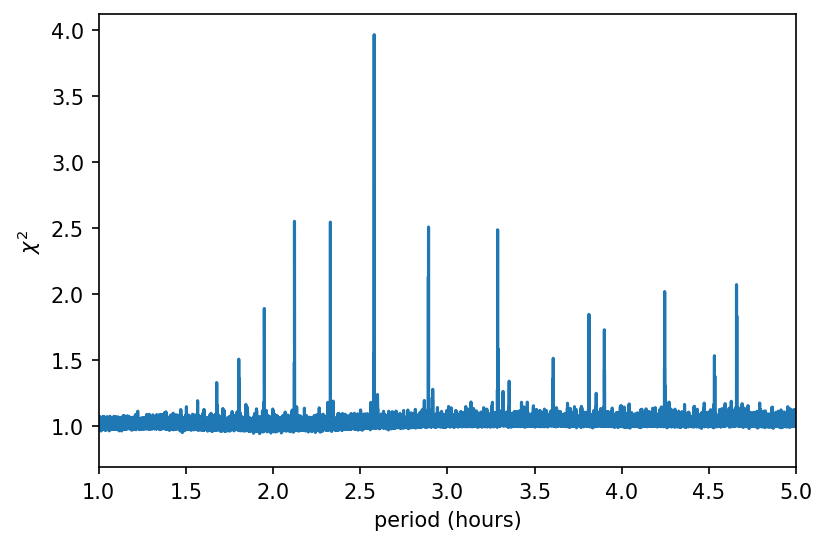

In [68]:
fig, ax = plt.subplots()
ax.plot(24/f, stats)
ax.set(xlabel='period (hours)', ylabel='$\chi^2$')
ax.set_xlim(1, 5)

Here, the $2.58$ hour period is more obvious; one can see the sequence of aliases of this feature imprinted by the window function of the data.

This algorithm is a version (a crude one!) of Phase Dispersion Minimization originally due to Stellingwerf (1978) and since improved in various ways. It's advantage is that it is fairly insensitive to the actual waveform of the signal -- all we assumed is that the phased signal is fairly smooth. Its disadvantage is that it is an $O(N_{freq}^2)$ algorithm, and as we have shown, for long observation periods $T$ we need $N_{freq}$ to be large.

At the expense of needing to make a somewhat more specific prior on the shape of the signal, another method is known as the Lomb-Scargle (or just Lomb) periodogram. As we will describe it, it too is an
$O(N_{freq}^2)$ algorithm, but it is possible to convert it to an $(N\log N)$ algorithm.

First find the mean and variance of the data as usual; these, of course, don't depend upon phasing:   

$$ \overline{m} = \frac{1}{N}\sum_{i=1}^N m_i\quad \sigma^2 = \frac{1}{N-1}\sum_{i=1}^N(m_i-\overline{m})^2 $$

Then the Lomb periodogram, an estimator for the spectral power as a function of angular frequency $\omega = 2\pi f$ is    

$$ P(\omega) = \frac{1}{2\sigma^2}\left\{  \frac{\left[\sum_i(m_i-\overline{m})\cos(\omega(t_i-\tau))\right]^2}{\sum_{i=1}^N\cos^2\omega(t_i-\tau)}
+\frac{\left[\sum_i(m_i-\overline{m})\sin(\omega(t_i-\tau))\right]^2}{\sum_{i=1}^N\sin^2\omega(t_i - \tau)}
\right\} $$
where $\tau$ is given by    

$$ \tan(2\pi \tau) = \frac{\sum_{i=1}^N \sin 2\omega t_i}{\sum_{i=1}^N \cos 2\omega t_i} $$

Lomb showed that this choice of $\tau$ makes the periodogram independent of any shift in the observation times $t_i$. 

More importantly, $P(\omega)$ gives precisely the result one would obtain by fitting the model   

$$ m(t) = A \cos\omega t + B \sin\omega t $$

to the data by linear least-squares. The method thus weights the data per point rather than per $\delta t$ as would methods based upon uniform sampling.

Press and Rybicki (1989 *Fast Algorithm for Spectral Analysis of Unevenly Sampled Data*, ApJ 338, p.277) gave a clever algorithm for speeding up the Lomb periodogram. It uses the FFT, but only as a computational device for fast evaluation
of the sin and cos sums, not as a spectral estimator.

Scargle (in 1982) examined the question of how to estimate the significance of a peak in the Lomb periodogram (something which is possible as well for Phase Dispersion Minimization but which we neglected to implement).

Scargle chose as a null hypothesis that the data consist of white noise (iid samples from a normal distribution). Because of the normalization $1/2\sigma^2$, under the null hypothesis $P(\omega)$ has an exponential distribution with unit mean; the probability that $P(\omega)$ lies on $[p, p+dp]$ is $e^{-p}dp$. Thus, if our data is $M$ iid samples of white noise, the probability that none of the frequencies has a value of $P(\omega)>p$ is $(1-e^{-p})^M$. Thus,

$$ P(>p) = 1 - (1-e^{-p})^M $$

is the *false alarm* probability, the significance level of any peak we actually do see in the periodogram.

This leaves us with the question: how many frequencies are actually independent? The question is actually a complex one as it depends in detail upon sampling. Extensive Monte Carlo experiments have shown that the most important effect comes when the data are concentrated in widely-separated "clumps" in time of a duration close to the period of the peak in question. If there are $Q$ frequencies in each clump, then $M\sim N/Q$, otherwise $M\sim N$.

For the important case of small false-alarm probability,

$$ P(>p) \sim Me^{-p} $$

Let's try this out on our LINEAR data sample.

peak at: 2.5801376 hours
significance: 4.233934436615276e-77
[0.08608722 0.07475596]


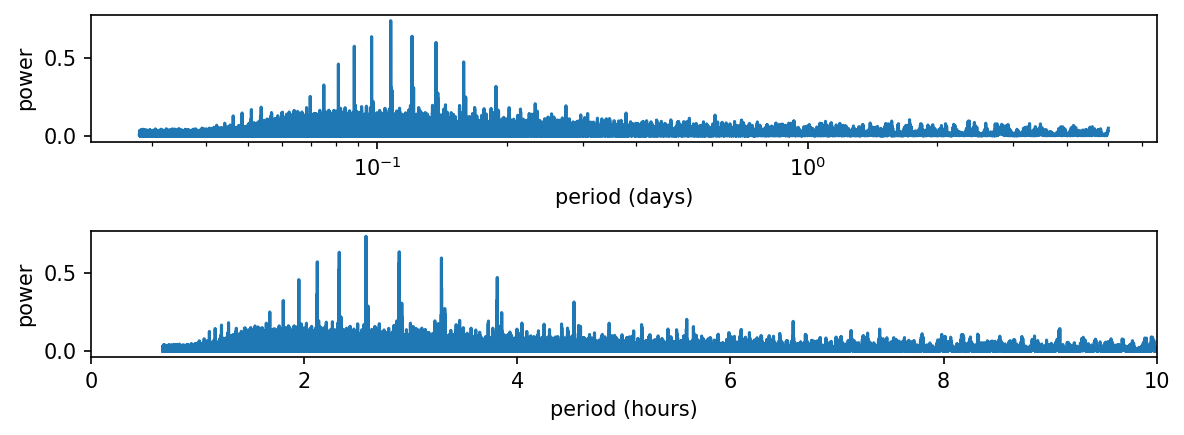

In [97]:
from astropy.timeseries import LombScargle

ls = LombScargle(tobs, mobs, merr)
f, power= ls.autopower(nyquist_factor=500, minimum_frequency=0.2)

p_days = 1. / f
p_hours = p_days * 24

fig, ax = plt.subplots(2,1, figsize=(8, 3))
ax[0].semilogx(p_days, power)
ax[0].set(xlabel='period (days)',
       ylabel='power')
#       xlim=(0.1, 1000));

ax[1].plot(p_hours, power)
ax[1].set(xlabel='period (hours)',
       ylabel='power',
       xlim=(0, 10));
fig.tight_layout()

ipeak = np.argmax(power)
print(f"peak at: {p_hours[ipeak]:.7f} hours")
print(f"significance: {ls.false_alarm_probability(power.max())}")

probs = [0.01, 0.05]
print(ls.false_alarm_level(probs))

hide_toggle()

Plotting a figure from VanderPlas' paper of the phased lightcurve and the single-harmonic model:

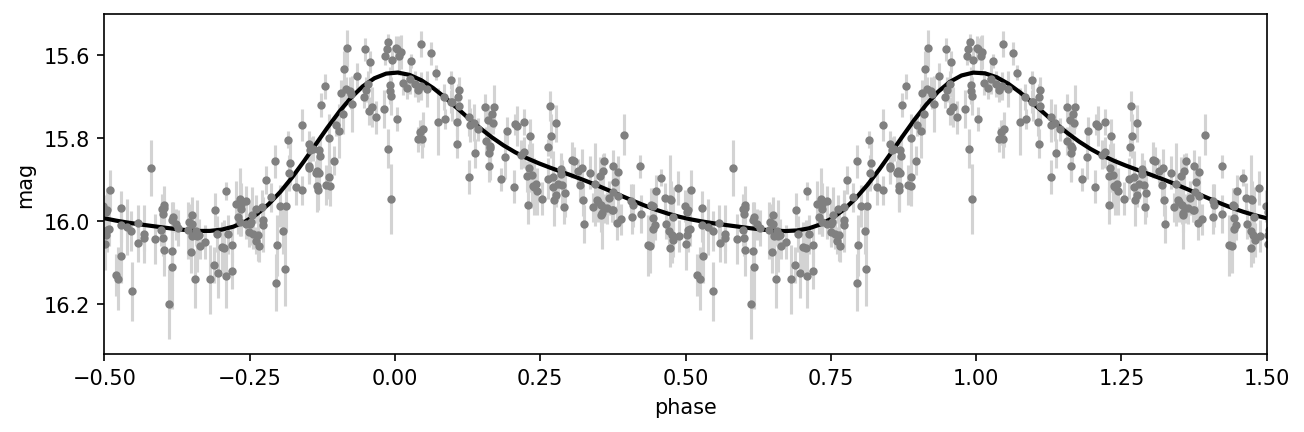

In [117]:
fig, ax = plt.subplots(figsize=(10, 3))

phase_model = np.linspace(-0.5, 1.5, 100)
best_frequency = f[np.argmax(power)]
mag_model = ls.model(phase_model / best_frequency, best_frequency)
phase = (tobs * best_frequency) % 1

for offset in [-1, 0, 1]:
    ax.errorbar(phase + offset, mobs, merr, fmt='.',
                color='gray', ecolor='lightgray', capsize=0);
ax.plot(phase_model, mag_model, '-k', lw=2)
ax.set(xlim=(-0.5, 1.5),
       xlabel='phase',
       ylabel='mag')
ax.invert_yaxis()

hide_toggle()

Clearly, we could do better here than fitting a single harmonic; the data clearly show that the waveform departs from a simple
sin wave, and this harmonic content is, of course, contained in the periodogram, but it is difficult to see... Here we try a 3-harmonic model

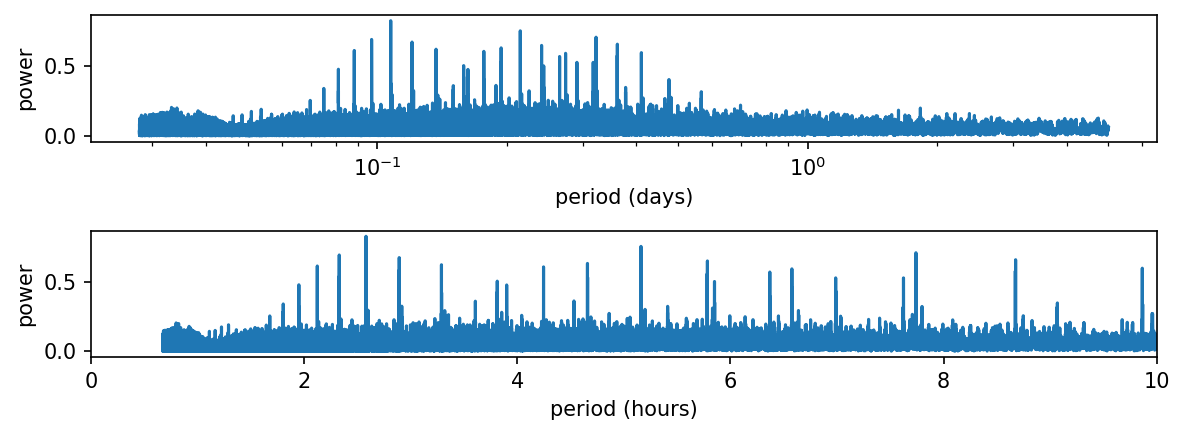

In [103]:
from astropy.timeseries import LombScargle

ls = LombScargle(tobs, mobs, merr, nterms=3)
f, power= ls.autopower(nyquist_factor=500, minimum_frequency=0.2)

p_days = 1. / f
p_hours = p_days * 24

fig, ax = plt.subplots(2,1, figsize=(8, 3))
ax[0].semilogx(p_days, power)
ax[0].set(xlabel='period (days)',
       ylabel='power')
#       xlim=(0.1, 1000));

ax[1].plot(p_hours, power)
ax[1].set(xlabel='period (hours)',
       ylabel='power',
       xlim=(0, 10));
fig.tight_layout()

hide_toggle()

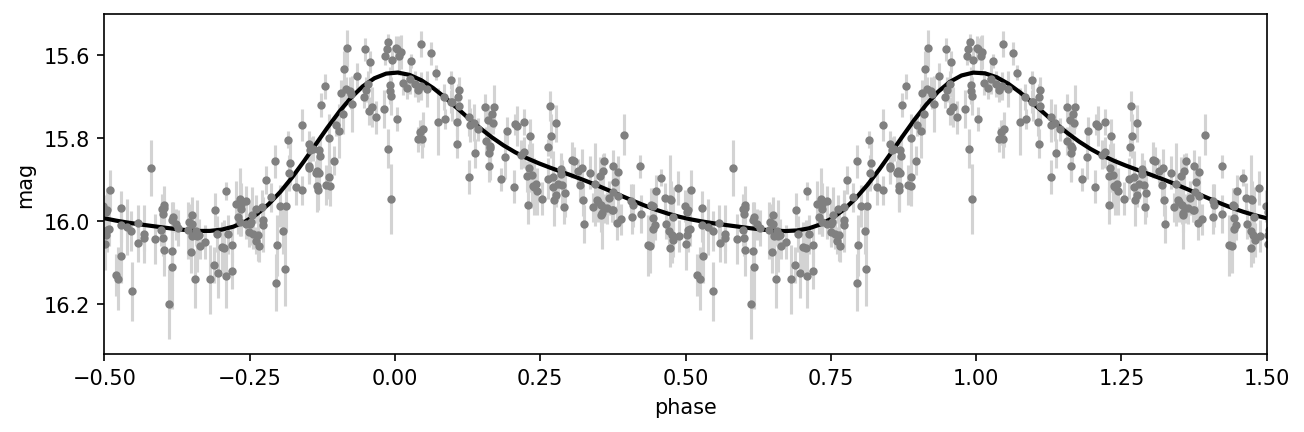

In [106]:
fig, ax = plt.subplots(figsize=(10, 3))

phase_model = np.linspace(-0.5, 1.5, 100)
best_frequency = f[np.argmax(power)]
mag_model = ls.model(phase_model / best_frequency, best_frequency)
phase = (tobs * best_frequency) % 1

for offset in [-1, 0, 1]:
    ax.errorbar(phase + offset, mobs, merr, fmt='.',
                color='gray', ecolor='lightgray', capsize=0);
ax.plot(phase_model, mag_model, '-k', lw=2)
ax.set(xlim=(-0.5, 1.5),
       xlabel='phase',
       ylabel='mag')
ax.invert_yaxis()

hide_toggle()

The Lomb periodogram is by no means the only way to attack this problem. In addition to methods like PDM, there are improvements to the Lomb periodogram. For example, assume we are observing data near a limiting magnitude.

The mean is then a poor representation of the underlying signal's mean. By adding an extra term to the fitting function,

$$ m(t) = m_0(\omega) + A \cos\omega t + B \sin\omega t $$

we get the Floating Mean version of the Lomb periodogram. In another figure from VanderPlas' paper,

    true frequency: 0.3
     standard fmax: 0.59992335950004
floating mean fmax: 0.30021311451929916


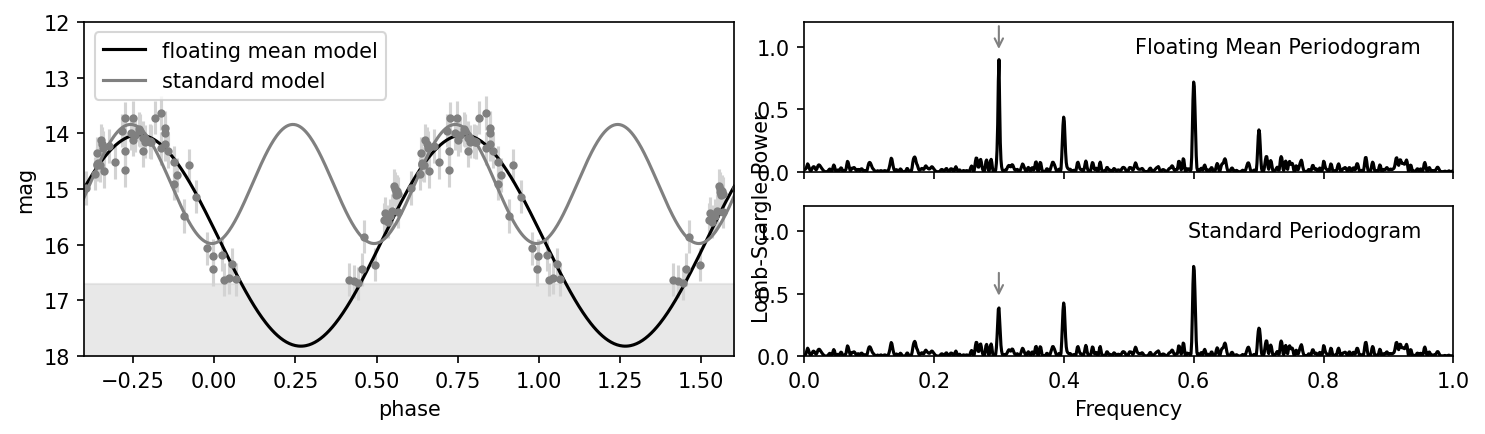

In [116]:
rng = np.random.RandomState(1324)
f0 = 0.3
t = rng.randint(0, 200, 100) + 0.15 * rng.randn(100)
dy = 0.3
y = 16 + 2 * np.sin(2 * np.pi * f0 * t) + dy * rng.randn(len(t))

mask = (y < 16.7)
t_out, y_out = t[~mask], y[~mask]
t, y = t[mask], y[mask]

ls_standard = LombScargle(t, y, dy, fit_mean=False)
ls_generalized = LombScargle(t, y, dy, fit_mean=True)

freq, power_standard = ls_standard.autopower(maximum_frequency=1)
freq, power_generalized = ls_generalized.autopower(maximum_frequency=1)

fmax_standard = freq[np.argmax(power_standard)]
fmax_generalized = freq[np.argmax(power_generalized)]

print(f"    true frequency: {f0}")
print(f"     standard fmax: {fmax_standard}")
print(f"floating mean fmax: {fmax_generalized}")

phase = (t * f0) % 1
phase_fit = np.linspace(-1, 2, 1000)

fig = plt.figure(figsize=(10, 3))
gs = plt.GridSpec(2, 2)

# Phased data
ax = fig.add_subplot(gs[:, 0])

ax.fill_between([-1, 2], 18, 16.7, color='lightgray', alpha=0.5)
for offset in (-1, 0, 1):
    ax.errorbar(phase + offset, y, dy, fmt='.',
                   color='gray', ecolor='lightgray', capsize=0)
ax.plot(phase_fit, ls_generalized.model(phase_fit / f0, fmax_generalized),
        color='black', label='floating mean model')
ax.plot(phase_fit, ls_standard.model(phase_fit / f0, fmax_standard),
        color='gray', label='standard model')
ax.legend(loc='upper left')
ax.set(xlim=(-0.4, 1.6),
       ylim=(18, 12),
       xlabel='phase',
       ylabel='mag');

#periodograms
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(freq, power_generalized, '-', color='black')
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.set(xlim=(0, 1),
        ylim=(0, 1.2))
ax1.text(0.95, 0.9, 'Floating Mean Periodogram',
         ha='right', va='top', transform=ax1.transAxes)
ax1.annotate('', (0.3, 0.95), (0.3, 1.2),
             arrowprops=dict(arrowstyle="->", color='gray'))
        
ax2 = fig.add_subplot(gs[1, 1])
ax2.plot(freq, power_standard, '-', color='black')
ax2.set(xlim=(0, 1),
        ylim=(0, 1.2),
        xlabel='Frequency')
ax2.text(0.95, 0.9, 'Standard Periodogram',
         ha='right', va='top', transform=ax2.transAxes)
ax2.annotate('', (0.3, 0.45), (0.3, 0.7),
             arrowprops=dict(arrowstyle="->", color='gray'))
        
fig.text(0.52, 0.5, 'Lomb-Scargle Power', ha='right', va='center', rotation=90)

fig.tight_layout()

hide_toggle()